# Intro
- This is the first jupyter notebook for the EIA interhemispheric assymmetry (IHA) seen during different solar cycles
- TEC comparison during the March equinox is carried out for different years
    - Peaks of the north and south EIA are traced and compared

# Reading New TEC Data and Producing Output Files

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')
import functions


from p_tqdm import p_map
from multiprocessing import Pool
import itertools

In [2]:
years_tot = list(range(2010, 2025))
functions = il.reload(functions)

for year in tqdm(years_tot):
    
    print(year)

    
    # Reading Madrigal Cedar data for +- 21 days around March equinox of 2010-2024
    # Files in below scratch folder are obtained by using multiple file download 
    # command in ASCII format and then doing `gunzip file.gz`  
    path = '/home/pxv220016/scratch/Qingyu_Cesar_EIA/' + str(year) + '_march_equinox/'
    files = os.listdir(path)
    tec_g = []
    columns = ['GDLAT', 'GLON', 'TEC', 'DT']
    grnd_tec = pd.DataFrame(columns=columns)

    def process_file(f):
        # Read function passed continuously during multiple processing to quicken the process
        df = pd.read_csv(path + f, sep=r'\s+')
        d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
        df['DT'] = d
        # Dropping unnecassary columns from the Dataframe
        df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
        if 'GDALT' in df.columns:
            df = df.drop(['GDALT'], axis=1)
        df = df[(df.GDLAT > -60) & (df.GDLAT < 60) & (df.GLON > -85) & (df.GLON < -45)].reset_index(drop=True)
        return df    
    # Speeding the process by using parallel processing
    tec_g = p_map(process_file, files)  # Parallel processing with progress bar
    grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
    grnd_tec = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])


    # Reading the Kp index values for all the days and filtering undesired points where Kp > 3
    file = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_' + str(year) + '_march.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
    m, d = zip(*date_kp)
    kp['date'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
    kp['kp'] = [i/10 for i in kp.Kp]
    kp = kp.drop(['Year', 'DOY', 'Hour','Kp'], axis = 1)
    grnd_tec0 = functions.kp_index_filtering(grnd_tec, kp)


    # Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
    t_start = dt.datetime.now() # just a timer
    with Pool(20) as pool:
        p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
    # Separating the data from output list 
    sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)
    t_total = dt.datetime.now() - t_start
    print(t_total)
    

    # Reordering the outputs and applying further conditions on magnetic coordinates
    grnd_temp = pd.DataFrame({'DT': sat_date, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt})
    grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= 5) & (grnd_tec1.MLON >= -5)].reset_index(drop=True)
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
    grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)

    
    # Writing the output into csv files for easy post processing
    grnd_tec2.to_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/' + str(year) + '_march_equinox.csv', index=False)


  0%|                                                    | 0/15 [00:00<?, ?it/s]

2010


  0%|          | 0/43 [00:00<?, ?it/s]

0:06:11.846766


  7%|██▋                                      | 1/15 [07:48<1:49:15, 468.28s/it]

2011


  0%|          | 0/43 [00:00<?, ?it/s]

0:06:58.397551


 13%|█████▍                                   | 2/15 [16:41<1:49:45, 506.58s/it]

2012


  0%|          | 0/43 [00:00<?, ?it/s]

0:09:58.324704


 20%|████████▏                                | 3/15 [29:21<2:04:27, 622.28s/it]

2013


  0%|          | 0/43 [00:00<?, ?it/s]

0:15:27.489398


 27%|██████████▉                              | 4/15 [48:41<2:33:00, 834.61s/it]

2014


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

0:18:55.106993


 33%|████████████▋                         | 5/15 [1:12:11<2:53:38, 1041.86s/it]

2015


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

0:12:19.608526


 40%|███████████████▏                      | 6/15 [1:28:00<2:31:34, 1010.54s/it]

2016


  0%|          | 0/43 [00:00<?, ?it/s]

0:14:54.766049


 47%|█████████████████▋                    | 7/15 [1:46:28<2:18:58, 1042.31s/it]

2017


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

0:09:25.962906


 53%|████████████████████▊                  | 8/15 [1:58:48<1:50:23, 946.18s/it]

2018


  0%|          | 0/43 [00:00<?, ?it/s]

0:14:59.839052


 60%|██████████████████████▊               | 9/15 [2:17:27<1:40:00, 1000.06s/it]

2019


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

0:21:43.133807


 67%|████████████████████████▋            | 10/15 [2:43:39<1:38:03, 1176.69s/it]

2020


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

0:20:07.867347


 73%|███████████████████████████▏         | 11/15 [3:08:55<1:25:21, 1280.40s/it]

2021


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

0:18:28.187781


 80%|█████████████████████████████▌       | 12/15 [3:32:02<1:05:39, 1313.08s/it]

2022


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

0:16:37.181824


 87%|█████████████████████████████████▊     | 13/15 [3:53:11<43:19, 1299.60s/it]

2023


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

0:16:18.463115


 93%|████████████████████████████████████▍  | 14/15 [4:13:59<21:24, 1284.09s/it]

2024


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

0:18:29.546132


100%|███████████████████████████████████████| 15/15 [4:37:22<00:00, 1109.51s/it]


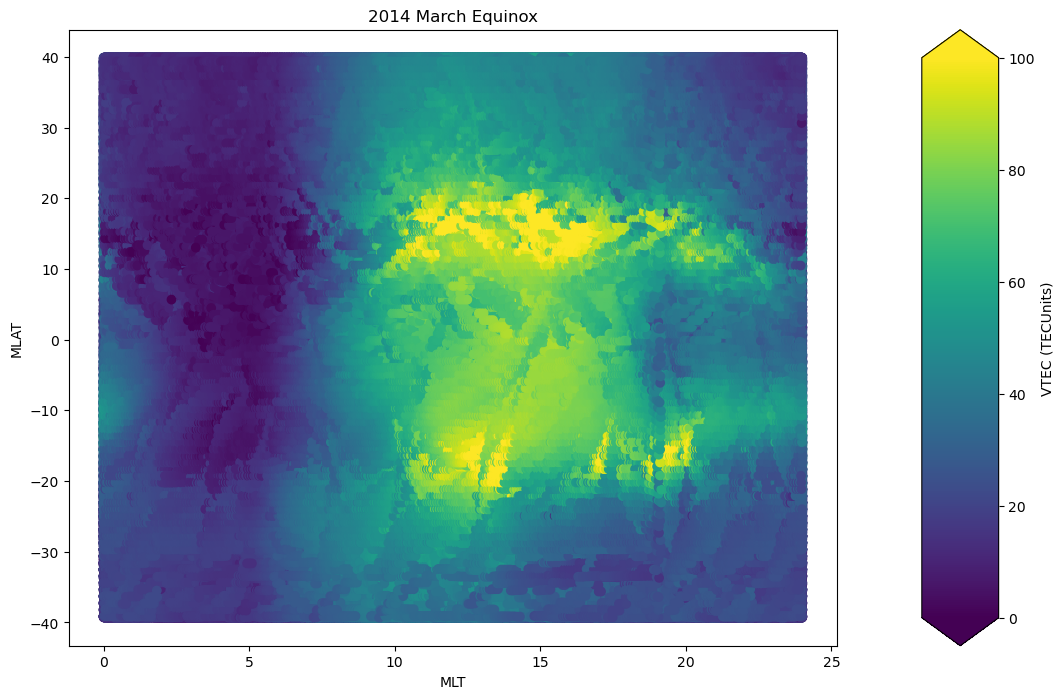

In [6]:
fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(grnd_tec2.MLT, grnd_tec2.MLAT, c=grnd_tec2.TEC, vmax=100, vmin=0)
ax[0].set_title('2014 March Equinox')
ax[0].set_ylabel('MLAT')
ax[0].set_xlabel('MLT')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
fig.show()


# Reading Data Directly From Saved Output Files

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')

100%|███████████████████████████████████████████| 15/15 [04:40<00:00, 18.72s/it]


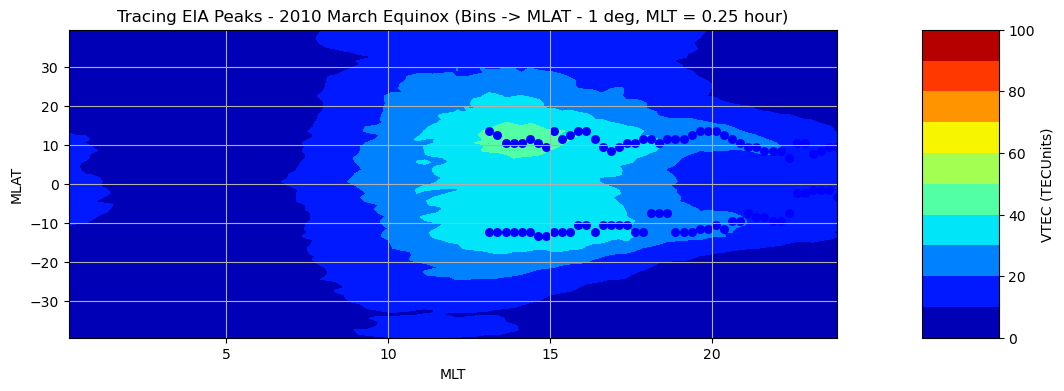

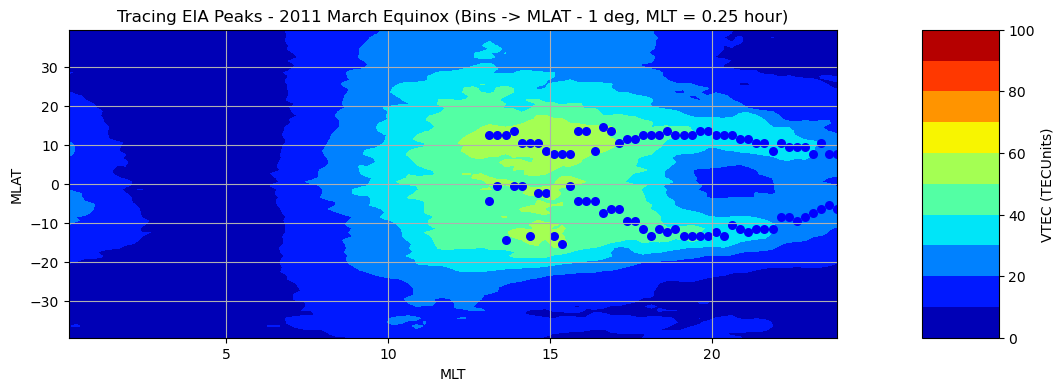

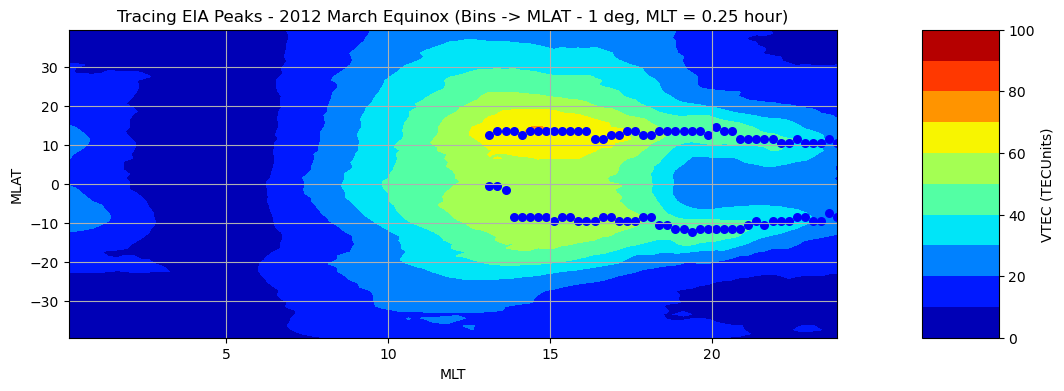

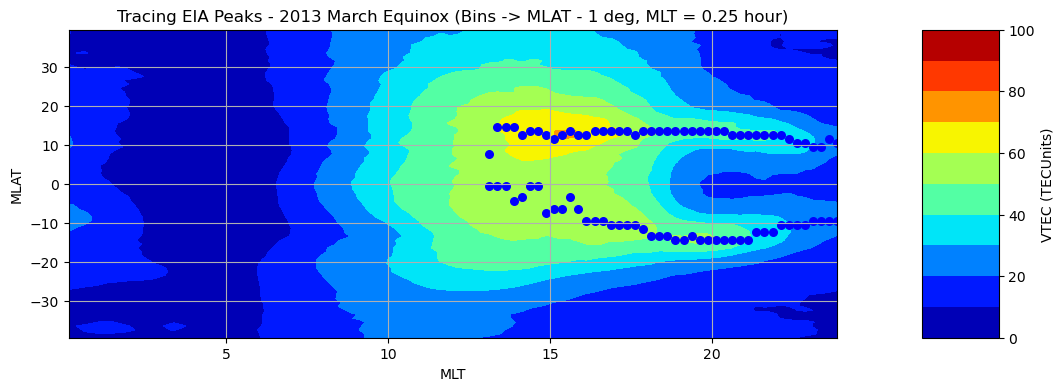

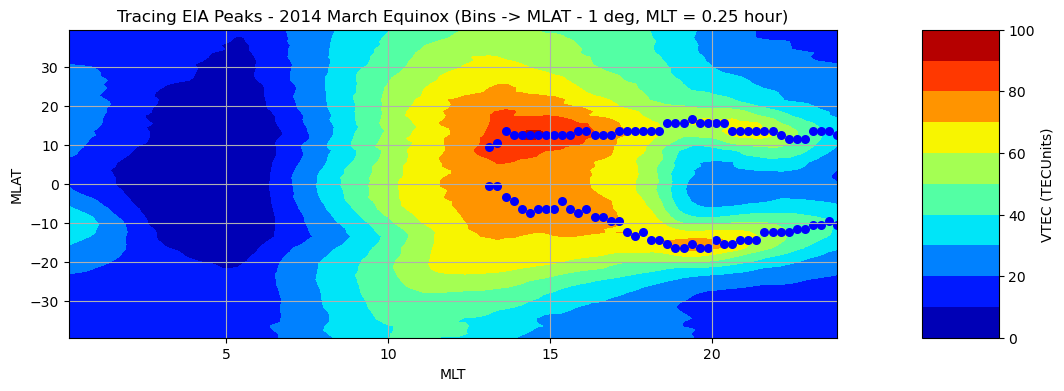

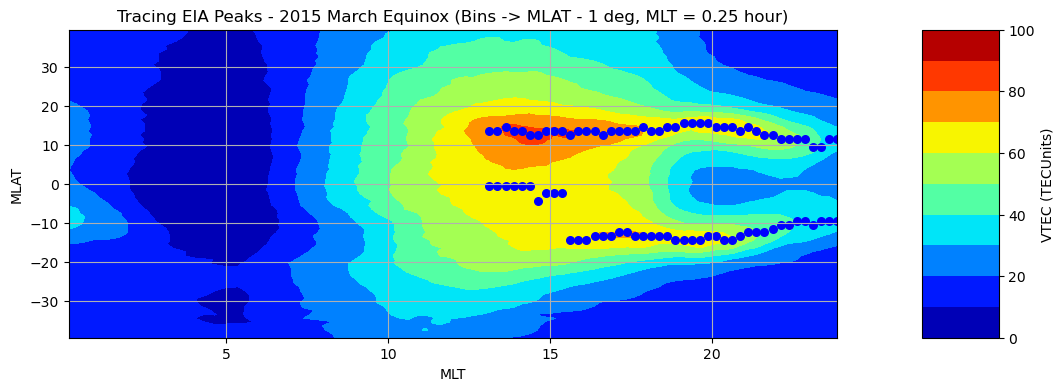

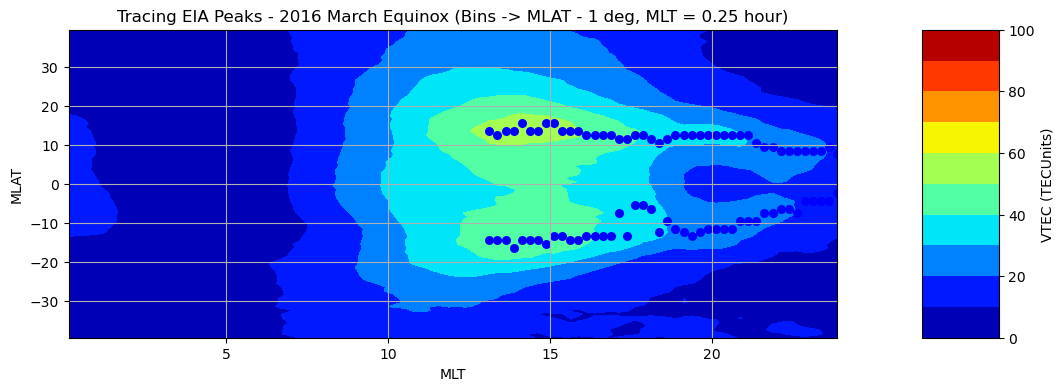

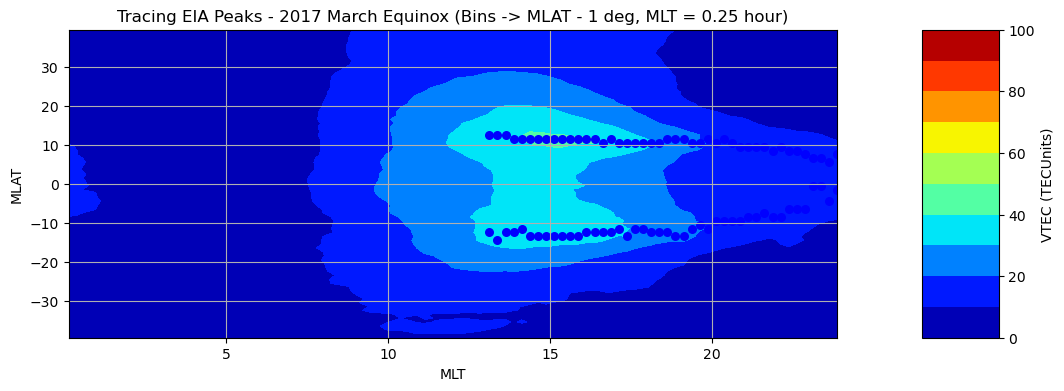

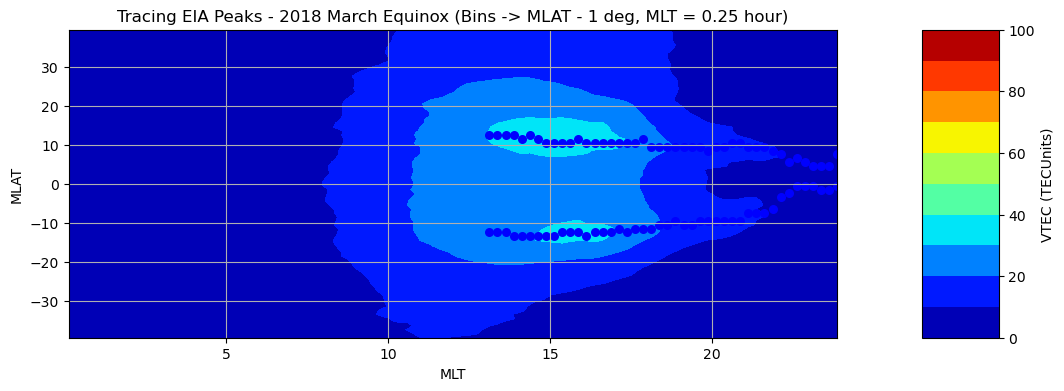

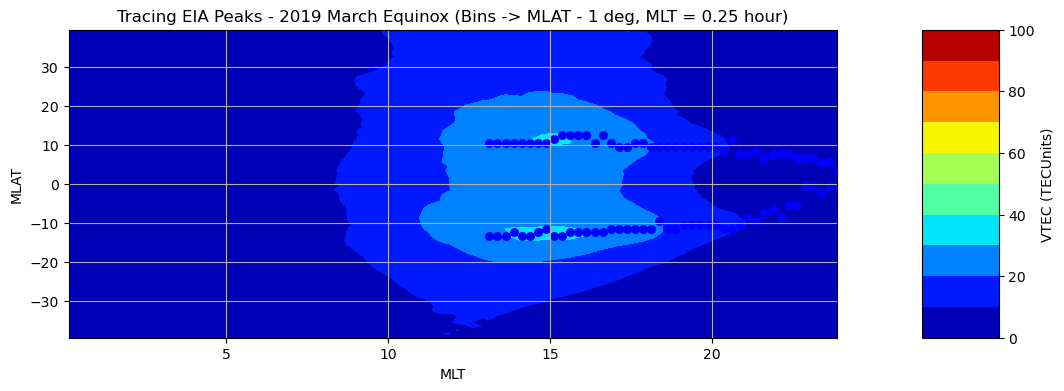

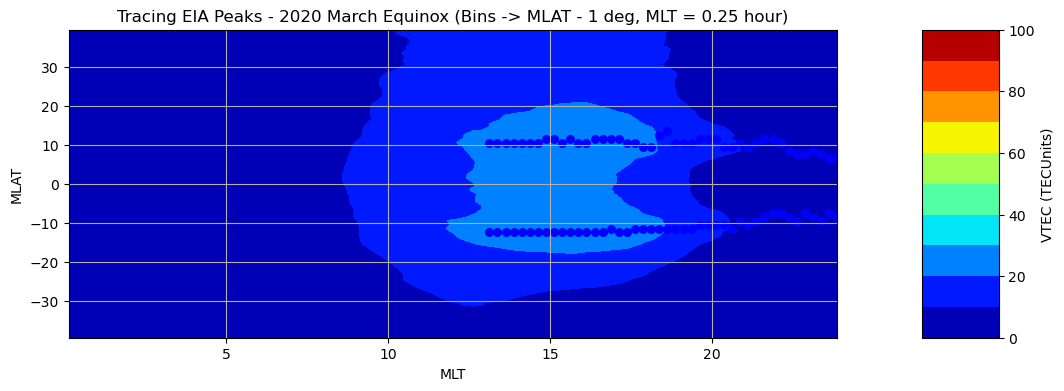

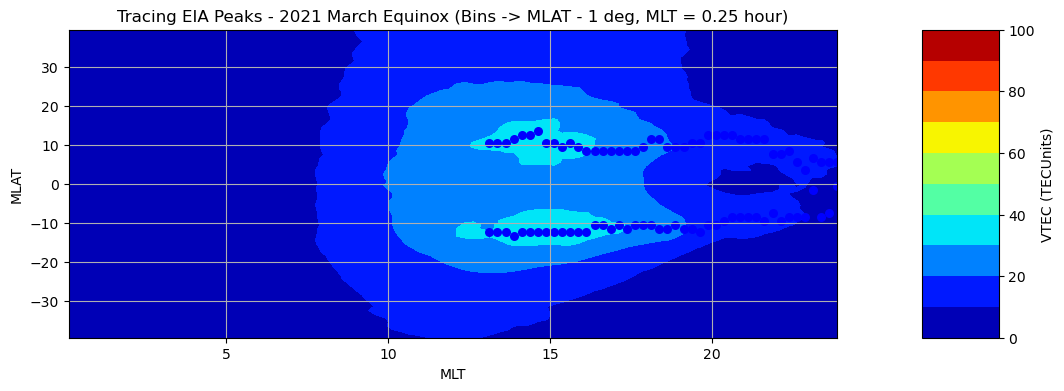

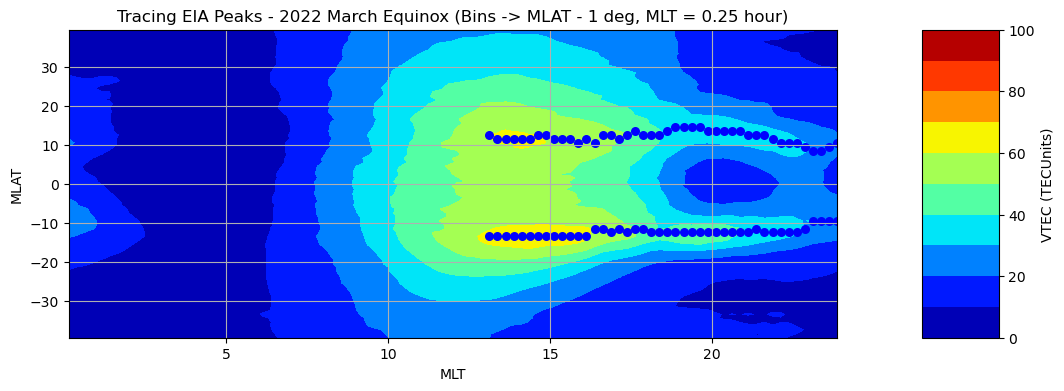

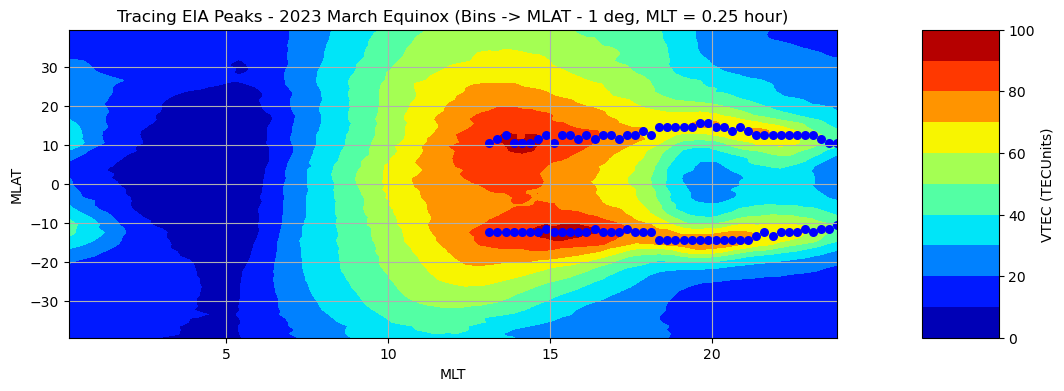

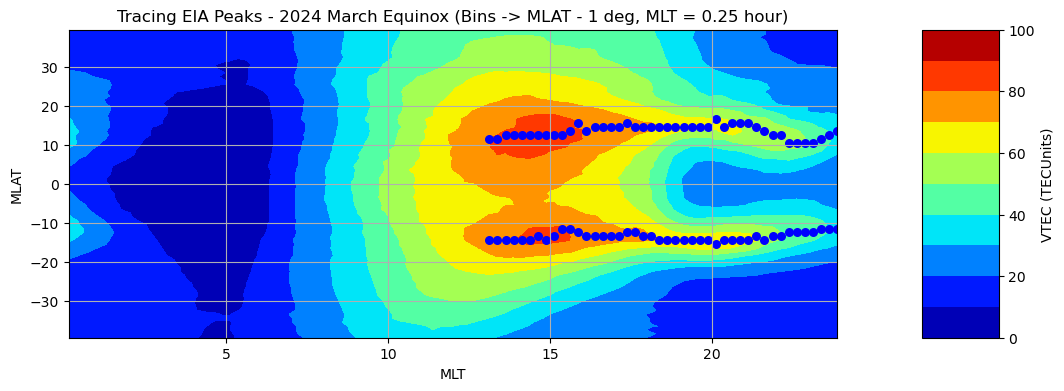

In [3]:
years = list(range(2010, 2025))

for year in tqdm(years):
    # Reading the data from output csv
    grnd_tec2 = pd.read_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/' + str(year) + '_march_equinox.csv')


    # Define the bin edges for MLAT and MLT
    bins_mlat = pd.cut(grnd_tec2['MLAT'], bins=pd.interval_range(start=-40, end=40, freq=1))
    bins_mlt = pd.cut(grnd_tec2['MLT'], bins=pd.interval_range(start=0, end=24, freq=0.25))
    
    # Create a new DataFrame with the bins
    grnd_tec2['MLAT_b'] = bins_mlat
    grnd_tec2['MLT_b'] = bins_mlt
    
    # Group by the bins (MLAT_b (primary) and MLT_b (secondary)) and calculate the average of TEC
    result = grnd_tec2.groupby(['MLAT_b', 'MLT_b'])['TEC'].mean().reset_index()
    # Converting the midpoint values of bins to float and assigning average TEC at those points
    result['MLAT_b'] = result['MLAT_b'].apply(lambda x: x.mid)
    result['MLT_b'] = result['MLT_b'].apply(lambda x: x.mid)
    result['MLAT_b'] = result['MLAT_b'].astype(float)
    result['MLT_b'] = result['MLT_b'].astype(float)

    
    result_t = result[result.MLT_b >= 13].reset_index(drop=True)
    result_n = result_t[result_t.MLAT_b > 0].reset_index(drop=True)
    result_s = result_t[result_t.MLAT_b < 0].reset_index(drop=True)
    result_n = result_n.loc[result_n.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    result_s = result_s.loc[result_s.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    
    i = 100*2*(result_n.TEC - result_s.TEC)/(result_n.TEC + result_s.TEC)
    result_ind = pd.DataFrame({'mlat_n': result_n.MLAT_b, 'mlat_s': result_s.MLAT_b, 'tec_n': result_n.TEC, 'tec_s': result_s.TEC, 'mlt': result_n.MLT_b, 'asy': i})
    result_ind.to_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/asy_' + str(year) + '_march.csv', index=False)


    X, Y = np.meshgrid(result.MLT_b.unique(), result.MLAT_b.unique())
    Z = result.TEC.values.reshape(X.shape)
    contour_levels = list(range(0, 101, 10))
    
    fig = plt.figure(figsize=(12,4))
    specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
    ax = []
    ax.append(fig.add_subplot(specs[0, 0]))
    c = ax[0].contourf(X, Y, Z, levels=contour_levels, cmap = 'jet')
    ax[0].scatter(result_ind.mlt, result_ind.mlat_n, c='b', s=30)
    ax[0].scatter(result_ind.mlt, result_ind.mlat_s, c='b', s=30)
    ax[0].set_title('Tracing EIA Peaks - ' + str(year) + ' March Equinox (Bins -> MLAT - 1 deg, MLT = 0.25 hour)')
    ax[0].set_ylabel('MLAT')
    ax[0].set_xlabel('MLT')
    ax[0].grid(True)
    
    cbar_ax = fig.add_subplot(specs[0,1])
    cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
    fig.savefig('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/eia_peaks_march_' + str(year) + '.jpg')
    fig.show()


# Comparing Asymmetry Index

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')

In [2]:
years = [2013, 2014, 2015, 2022, 2023, 2024]

asy_ind = []

for y in years:
    f = pd.read_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/asy_' +str(y) + '_march.csv')
    asy_ind.append(f)

In [19]:
solar_cyc = [[list(range(2013, 2016))], [list(range(2022, 2025))]]
sc = ['Baseline SC 24', 'Baseline SC 25']

sc_base = []

for s in tqdm(solar_cyc):
    for periods in s:
        columns = ['mlt', 'asy']
        baseline = pd.DataFrame(columns=columns)
        
        for p in periods:
            a = pd.read_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/asy_' + str(p) + '_march.csv')
            a = a.drop(['mlat_n', 'mlat_s', 'tec_n', 'tec_s'], axis=1)
            baseline = pd.concat([baseline, a], axis=0).reset_index(drop=True)
        
        baseline = baseline.sort_values(by=['mlt'], ascending=[True])
        bins_mlt = pd.cut(baseline['mlt'], bins=pd.interval_range(start=0, end=24, freq=0.75))
        baseline['mlt'] = bins_mlt
        baseline = baseline.groupby(['mlt'])['asy'].mean().reset_index()
        baseline['mlt'] = baseline['mlt'].apply(lambda x: x.mid)
        baseline['mlt'] = baseline['mlt'].astype(float)
        baseline.dropna(inplace=True)
        print(baseline)
        break
    sc_base.append(baseline)


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 54.43it/s]

       mlt        asy
17  13.125  11.623045
18  13.875  16.562019
19  14.625  19.100690
20  15.375  19.212368
21  16.125  15.184305
22  16.875   9.073350
23  17.625   1.577576
24  18.375  -5.589366
25  19.125 -11.917330
26  19.875  -9.587468
27  20.625   0.625587
28  21.375  14.079367
29  22.125  18.119455
30  22.875  14.220892
31  23.625  -1.719644
       mlt        asy
17  13.125   2.755726
18  13.875   1.572047
19  14.625  -1.347222
20  15.375  -4.358789
21  16.125  -5.366516
22  16.875  -1.826503
23  17.625  -1.829315
24  18.375  -3.874299
25  19.125 -12.637882
26  19.875 -14.412553
27  20.625 -10.250075
28  21.375  -0.217226
29  22.125   5.512614
30  22.875   2.817658
31  23.625  -4.641877


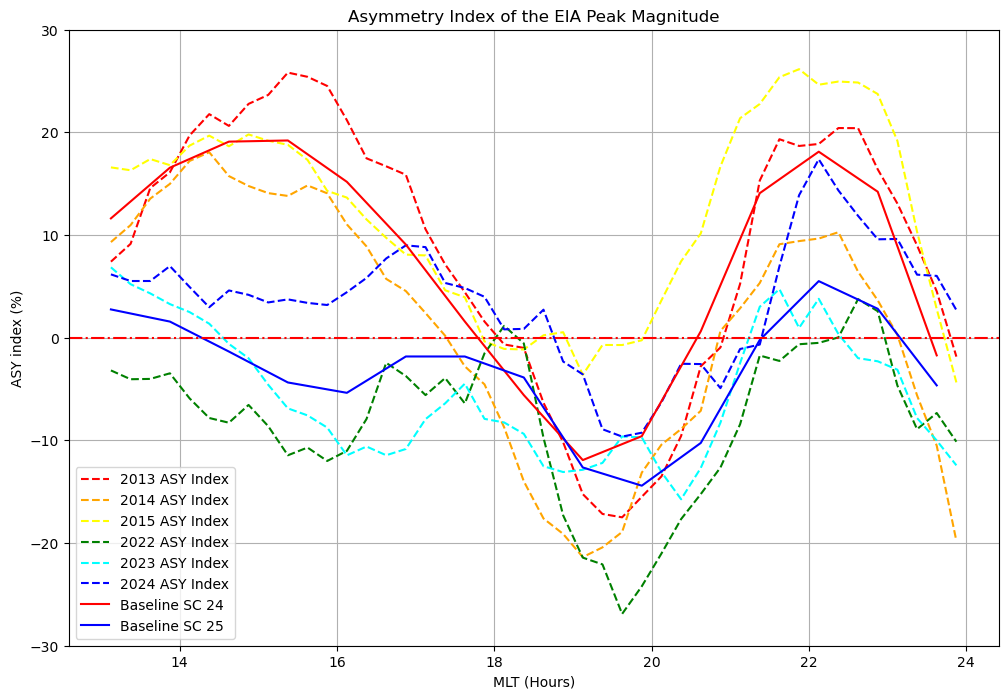

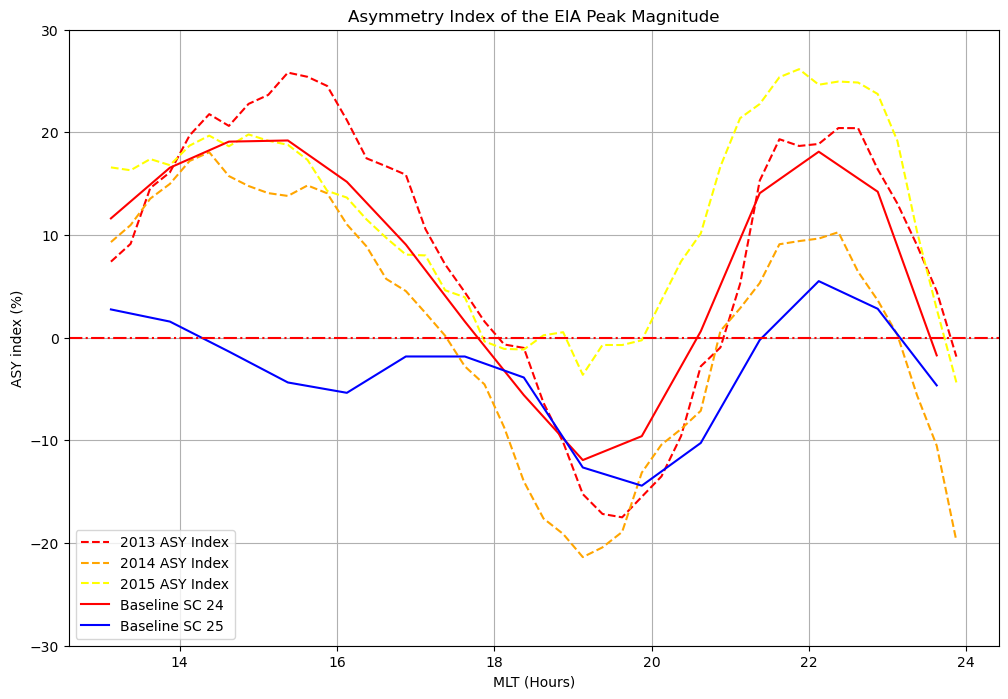

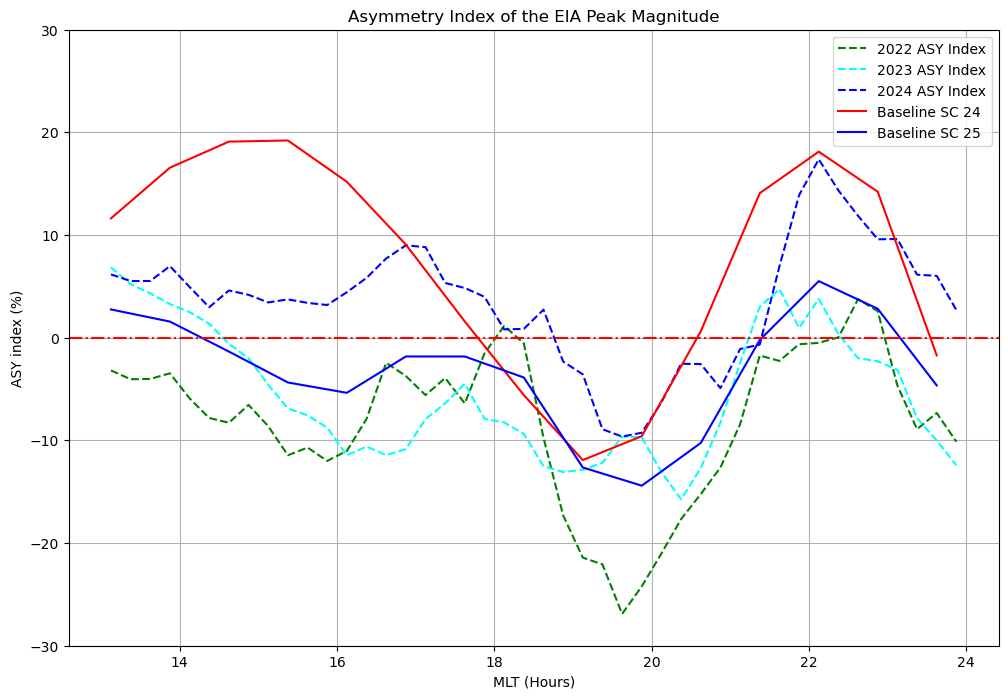

In [30]:

color = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue']
plt.figure(figsize=(12,8))
for a, y, c in zip(asy_ind, years, color):
    plt.plot(a.mlt, a.asy, linestyle = '--', label=str(y) + ' ASY Index', c = c)
color_sc = ['red', 'blue']
for b, s, cs in zip(sc_base, sc, color_sc):
    plt.plot(b.mlt, b.asy, label = s, c=cs)
plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlabel('MLT (Hours)')
plt.grid(True)
plt.show()


plt.figure(figsize=(12,8))
for a, y, c in zip(asy_ind[:3], years[:3], color[:3]):
    plt.plot(a.mlt, a.asy, linestyle = '--', label=str(y) + ' ASY Index', c = c)
color_sc = ['red', 'blue']
plt.plot(sc_base[0].mlt, sc_base[0].asy, label = sc[0], c=color_sc[0])
plt.plot(sc_base[1].mlt, sc_base[1].asy, label = sc[1], c=color_sc[1])
plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlabel('MLT (Hours)')
plt.grid(True)
plt.show()


plt.figure(figsize=(12,8))
for a, y, c in zip(asy_ind[3:], years[3:], color[3:]):
    plt.plot(a.mlt, a.asy, linestyle = '--', label=str(y) + ' ASY Index', c = c)
color_sc = ['red', 'blue']
plt.plot(sc_base[0].mlt, sc_base[0].asy, label = sc[0], c=color_sc[0])
plt.plot(sc_base[1].mlt, sc_base[1].asy, label = sc[1], c=color_sc[1])
plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlabel('MLT (Hours)')
plt.grid(True)
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')
import functions


from p_tqdm import p_map
from multiprocessing import Pool
import itertools